# Data Mining project
## Members:
- Mateusz Idziejczak 155842
- Mateusz Stawicki 155900
- Anastasiya
- Baris
## Dataset
The dataset we are going to use is the [Titanic](https://www.kaggle.com/competitions/titanic) dataset from Kaggle. It contains data of 2224 passengers. The dataset is in a CSV format and contains 12 columns. The columns are: `PassengerId`, `Survived`, `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, `Embarked`. 
- The `Survived` column is the target column and the other columns are the features. 
- The `Survived` column contains binary values: 0 if the passenger did not survive and 1 if the passenger survived. 
- The `Pclass` column contains the class of the passenger. 
- The `Name` column contains the name of the passenger. 
- The `Sex` column contains gender of the passenger. 
- The `Age` column contains the age of the passenger. 
- The `SibSp` column contains the number of siblings and spouses of the passenger. 
- The `Parch` column contains the number of parents and children of the passenger. 
- The `Ticket` column contains the ticket number of the passenger. 
- The `Fare` column contains the fare of the passenger. 
- The `Cabin` column contains the cabin number of the passenger. 
- The `Embarked` column contains the port of embarkation of the passenger. 

## Implementation
### Data loading
First we need to load the data from the CSV file. We will use the pandas library to do this.


In [163]:
import pandas as pd

data = pd.read_csv('data/train.csv')

### Data exploration
Now we will explore the data to see what it contains.

In [164]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [165]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data preprocessing
Before we can start building the model we need to preprocess the data. This includes:
- splitting the data into features and labels
- Removing columns that are not useful
- Handling missing values
- Encoding categorical variables
- Scaling the data
- Splitting the data into training and testing sets

#### Splitting the data into features and labels

In [166]:
X = data.drop('Survived', axis=1)
y = data['Survived']

#### Removing columns that are not useful
We will remove the `PassengerId`, `Name` and `Ticket` columns as they are not useful for the model.

In [167]:
X = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

#### Handling missing values
We will fill the missing values in the `Age` columns with the mean and mode respectively.

In [168]:
X.isna().sum().to_frame().reset_index().rename(columns={0: 'Missing values'})

,index,Missing values
0,Pclass,0
1,Sex,0
2,Age,177
3,SibSp,0
4,Parch,0
5,Fare,0
6,Embarked,2


In [169]:
X['Age'] = X['Age'].fillna(X['Age'].mean())
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])

#### Encoding categorical variables
We will encode the `Embarked` and `Sex` column using label encoding.

In [170]:
columns_to_encode = ['Embarked', 'Sex']
try:
    from sklearn.preprocessing import LabelEncoder
    
    label_encoder = LabelEncoder()
    for column in columns_to_encode:
        X[column] = label_encoder.fit_transform(X[column])
except KeyError:
    print('Columns already encoded')

We will also split Age into 5 age groups. We need to know how survival rate depends on age.

In [171]:
df_X = X.copy()
df_X['Survived'] = y
bins = [0, 9, 14, 42, 57, 59, 100]
df_X['AgeBin'] = pd.cut(df_X['Age'], bins=bins, labels=[0, 1, 2, 3, 4, 5])
df_X.groupby(['AgeBin', 'Survived']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

/var/folders/yc/wnx9vsb14tx1110ygs64rfvh0000gn/T/ipykernel_44764/1851291576.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_X.groupby(['AgeBin', 'Survived']).size().unstack().apply(lambda x: x / x.sum(), axis=1)


Survived,0,1
AgeBin,,
0,0.387097,0.612903
1,0.533333,0.466667
2,0.635036,0.364964
3,0.614583,0.385417
4,0.571429,0.428571
5,0.730769,0.269231


In [172]:
def age_category(age):
    if age <= bins[1]:
        return 0
    elif age <= bins[2]:
        return 1
    elif age <= bins[3]:
        return 2
    elif age <= bins[4]:
        return 3
    elif age <= bins[5]:
        return 4
    else:
        return 5

X['Age'] = X['Age'].apply(age_category)

and count the family size.

In [173]:
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
X = X.drop(['SibSp', 'Parch'], axis=1)

#### Scaling the data
We will scale the data using the MinMaxScaler.

In [174]:
from sklearn.preprocessing import MinMaxScaler

X1 = X[['Fare']]
X2 = X.drop(['Fare'], axis=1)
scaler = MinMaxScaler().fit(X1)
X1 = pd.DataFrame(scaler.transform(X1), columns=X1.columns)
X = pd.concat([X1, X2], axis=1)

#### Splitting the data into training and testing sets
We will split the data into training and testing sets using the `train_test_split` method from the `sklearn` library.

In [175]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Final data
The final data looks like this:

In [176]:
X.head(15)

,Fare,Pclass,Sex,Age,Embarked,FamilySize
0,0.014151,3,1,2,2,2
1,0.139136,1,0,2,0,2
2,0.015469,3,0,2,2,1
3,0.103644,1,0,2,2,2
4,0.015713,3,1,2,2,1
5,0.016510,3,1,2,1,1
6,0.101229,1,1,3,2,1
7,0.041136,3,1,0,2,5
8,0.021731,3,0,2,2,3
9,0.058694,2,0,1,0,2


### Selecting features
Now we will see the features that will affect model the most. We will use the `SelectKBest` method from the `sklearn` library to select the best features.

In [177]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best_features = SelectKBest(score_func=chi2, k=5)
fit = best_features.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
feature_scores = pd.concat([dfcolumns, dfscores], axis=1)
feature_scores.columns = ['Feature', 'Score']
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
feature_scores

,Feature,Score
2,Sex,92.702447
1,Pclass,30.873699
4,Embarked,10.202525
0,Fare,8.819172
3,Age,3.300942
5,FamilySize,0.336787


### Model building
Now we will build the model. We will use the Perceptron and the Random Forest Classifier.

#### Perceptron

In [178]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8156424581005587

#### Random Forest Classifier

In [179]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8324022346368715

### Model evaluation
Now we will evaluate the models using the confusion matrix and the classification report.

In [180]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = perceptron.predict(X_test)
print('Perceptron')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred = random_forest.predict(X_test)
print('Random Forest Classifier')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Perceptron
[[93 13]
 [20 53]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       106
           1       0.80      0.73      0.76        73

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179

Random Forest Classifier
[[89 17]
 [13 60]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       106
           1       0.78      0.82      0.80        73

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



### Conclusion
The Random Forest Classifier model performed better than the Perceptron model. The Random Forest Classifier model had an accuracy of 0.84, while the Perceptron model had an accuracy of 0.78. The Random Forest Classifier model also had better precision, recall and F1-score than the Perceptron model. This shows that the Random Forest Classifier model is better at predicting whether a passenger survived the Titanic disaster or not.

----------\------

### Additional scripts
#### Searching for best age bins

In [181]:
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np
# 
# max_accuracy = 0
# max_bins = []
# for d in range(1, 100000):
#     # (i, j, g, h) = np.random.randint(6, 75, 4)
#     i = np.random.randint(4, 25)
#     j = np.random.randint(15, 35)
#     h = np.random.randint(25, 55)
#     g = np.random.randint(50, 75)
#     bins = sorted([0, i, j, h, g, 100])
#     copy = X.copy()
# 
# 
#     def age_category(age):
#         if age <= bins[1]:
#             return 0
#         elif age <= bins[2]:
#             return 1
#         elif age <= bins[3]:
#             return 2
#         elif age <= bins[4]:
#             return 3
#         elif age <= bins[5]:
#             return 4
#         elif age <= bins[6]:
#             return 5
#         else:
#             return 6
# 
# 
#     copy['Age'] = copy['Age'].apply(age_category)
#     total_accuracy = 0
#     for _ in range(1):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#         random_forest = RandomForestClassifier()
#         random_forest.fit(X_train, y_train)
#         y_pred = random_forest.predict(X_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         total_accuracy += accuracy
#     total_accuracy /= 1
#     if total_accuracy > max_accuracy:
#         max_accuracy = total_accuracy
#         max_bins = bins
#         print(max_accuracy, max_bins, d)
#     if d % 500 == 0:
#         print(max_accuracy, max_bins, d)

### Feature extraction

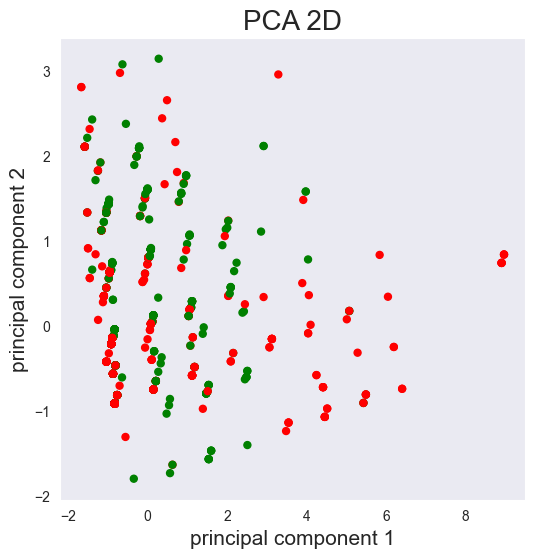

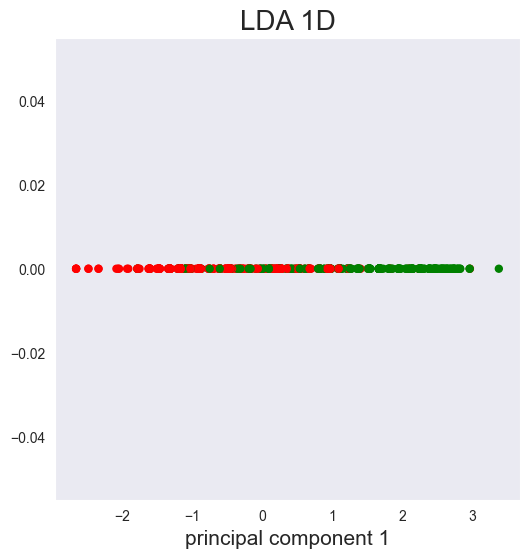

In [193]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components = 2)
lda = LDA(n_components = 1)

Wine_new = pd.DataFrame(pca.fit_transform(X), columns = ['PC1','PC2'])
Wine_new2 = pd.DataFrame(lda.fit_transform(X,y), columns = ['PC1'])
colors = np.array(['red', 'green'])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('PCA 2D', fontsize=20)
ax.set_xlabel('principal component 1', fontsize=15)
ax.set_ylabel('principal component 2', fontsize=15)
ax.grid()
ax.scatter(Wine_new.PC1, Wine_new.PC2, c=colors[y], s=25)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('LDA 1D', fontsize=20)
ax.set_xlabel('principal component 1', fontsize=15)
ax.grid()
ax.scatter(Wine_new2.PC1, [0]*len(Wine_new2), c=colors[y], s=25)